In [174]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 

In [ ]:
## remove the conv layers, relu--> linear regression works
## remove the edge index to see if the graph is helping
## r values which have never see before 

In [175]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.   ,  2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133,
        0.067,  0.033, 0.37,7.4])

In [118]:
np.log(rs)

array([ 2.99573227,  2.30258509,  0.69314718,  0.        , -0.69314718,
       -1.60943791, -2.30258509, -2.99573227, -3.68887945,  1.60943791,
        0.91629073,  2.59024217,  1.2038728 ,  0.28743204, -0.40496523,
       -1.25176347, -2.01740615, -2.70306266, -3.41124772, -0.99425227,
        2.00148   ])

In [176]:
rs.sort()

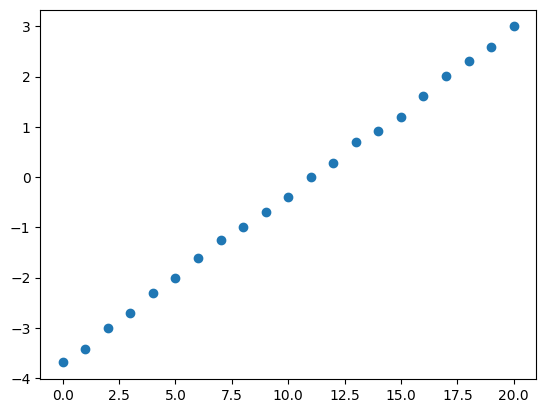

In [122]:
plt.scatter(range(21),np.log(rs))
# plt.axhline(2)
# plt.axhline(-2.8)

In [177]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
WN2 = np.dot(WN, WN)
# prob = WN[:,1858]
prob = WN2[:,1858]
prob_2d = prob.reshape(-1,1)

In [178]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [179]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [230]:
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
           5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
        0.067:3,  0.033:3, 0.37:2,7.4:0}

In [181]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []

for r_idx in range(21):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
#         g_i_new = g_i[:,10:] * prob_2d
        g_i_new = g_i[:,10:]
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

0.025 3
0.033 3
0.05 3
0.067 3
0.1 2
0.133 2
0.2 2
0.286 2
0.37 2
0.5 1
0.667 1
1.0 1
1.333 1
2.0 1
2.5 1
3.333 1
5.0 0
7.4 0
10.0 0
13.333 0
20.0 0


In [182]:
from torch.utils.data import random_split
all_data_len = len(dataset)
train_data, test_data = random_split(dataset, [int(all_data_len*0.8), int(all_data_len*0.2)])

In [184]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)     
        self.conv2 = GCNConv(128, 64) 
        self.conv3 = GCNConv(64, 16) 
        self.conv4 = GCNConv(16, 8) 
        self.fc = torch.nn.Linear(8, 1)
#         self.fc = torch.nn.Linear(num_node_features, 1)


    """
        hyperparameters:
        - number of hidden layers
        - number of hidden channels
        - dropout rate (now it's zero)
        - learning rate <- most important to tune
        - weight decay
        - etc etc.
    """

    def forward(self, data):
#         x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
#         edge_index, edge_weight = add_self_loops(edge_index, edge_attr=edge_weight, num_nodes=x.size(0))
        
        x, batch = data.x, data.batch
        edge_index = torch.Tensor([[],[]]).to(x.device).long()
 
        
        x = self.conv1(x, edge_index)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv2(x, edge_index)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv3(x, edge_index)
#         x = F.leaky_relu(x)
        x = F.elu(x)
        
        x = self.conv4(x, edge_index)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=50).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
        
       
        loss = F.mse_loss(output, label) 
#         loss = F.cross_entropy(output, label)
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        
        optimizer.step() 
        results.append(output)
    
    return loss_all / len(myloader.dataset), results, y_true



counter = 0
count_epochs = 0
best = float("inf")
epochs = 90
patience = 5
loss_ep= []
 
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    loss, myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
#     ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss))
    if loss < best:
        best = loss
        counter = 0
    else:
        counter += 1
        count_epochs += 1
        
    if counter > patience:
        break
        # print(f"Epoch: {​​​​​​epoch:03d}​​​​​​, Loss: {​​​​​​loss:.4f}​​​​​​")
#     scheduler.step()
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
print("\n", "Stopped early at epoch: ", count_epochs)


Epoch: 001, Loss: 5.8726:   1%|▏                 | 1/90 [00:23<35:25, 23.89s/it]

Epoch: 001, Loss: 5.87263


Epoch: 002, Loss: 4.0862:   2%|▍                 | 2/90 [00:47<34:58, 23.84s/it]

Epoch: 002, Loss: 4.08622


Epoch: 003, Loss: 3.9338:   3%|▌                 | 3/90 [01:11<34:28, 23.77s/it]

Epoch: 003, Loss: 3.93382


Epoch: 004, Loss: 2.5750:   4%|▊                 | 4/90 [01:35<34:10, 23.84s/it]

Epoch: 004, Loss: 2.57498


Epoch: 005, Loss: 1.2905:   6%|█                 | 5/90 [01:59<33:43, 23.80s/it]

Epoch: 005, Loss: 1.29046


Epoch: 006, Loss: 1.0903:   7%|█▏                | 6/90 [02:23<33:23, 23.85s/it]

Epoch: 006, Loss: 1.09028


Epoch: 007, Loss: 0.9323:   8%|█▍                | 7/90 [02:46<32:55, 23.80s/it]

Epoch: 007, Loss: 0.93231


Epoch: 008, Loss: 0.7174:   9%|█▌                | 8/90 [03:10<32:33, 23.82s/it]

Epoch: 008, Loss: 0.71743


Epoch: 009, Loss: 0.6420:  10%|█▊                | 9/90 [03:34<32:07, 23.79s/it]

Epoch: 009, Loss: 0.64196


Epoch: 010, Loss: 0.6390:  11%|█▉               | 10/90 [03:58<31:48, 23.86s/it]

Epoch: 010, Loss: 0.63897


Epoch: 011, Loss: 0.7753:  12%|██               | 11/90 [04:22<31:22, 23.84s/it]

Epoch: 011, Loss: 0.77527


Epoch: 012, Loss: 0.5768:  13%|██▎              | 12/90 [04:46<31:08, 23.96s/it]

Epoch: 012, Loss: 0.57684


Epoch: 013, Loss: 0.5383:  14%|██▍              | 13/90 [05:10<30:41, 23.92s/it]

Epoch: 013, Loss: 0.53831


Epoch: 014, Loss: 0.4767:  16%|██▋              | 14/90 [05:34<30:16, 23.90s/it]

Epoch: 014, Loss: 0.47674


Epoch: 015, Loss: 0.4444:  17%|██▊              | 15/90 [05:57<29:47, 23.83s/it]

Epoch: 015, Loss: 0.44440


Epoch: 016, Loss: 0.4875:  18%|███              | 16/90 [06:21<29:23, 23.84s/it]

Epoch: 016, Loss: 0.48752


Epoch: 017, Loss: 0.5184:  19%|███▏             | 17/90 [06:45<28:55, 23.78s/it]

Epoch: 017, Loss: 0.51838


Epoch: 018, Loss: 0.5173:  20%|███▍             | 18/90 [07:08<28:31, 23.77s/it]

Epoch: 018, Loss: 0.51732


Epoch: 019, Loss: 0.4880:  21%|███▌             | 19/90 [07:32<28:03, 23.72s/it]

Epoch: 019, Loss: 0.48805


Epoch: 020, Loss: 0.4739:  22%|███▊             | 20/90 [07:56<27:41, 23.74s/it]

Epoch: 020, Loss: 0.47385


Epoch: 021, Loss: 0.4420:  23%|███▉             | 21/90 [08:20<27:17, 23.74s/it]

Epoch: 021, Loss: 0.44201


Epoch: 022, Loss: 0.4716:  24%|████▏            | 22/90 [08:43<26:55, 23.76s/it]

Epoch: 022, Loss: 0.47164


Epoch: 023, Loss: 0.4097:  26%|████▎            | 23/90 [09:07<26:34, 23.80s/it]

Epoch: 023, Loss: 0.40967


Epoch: 024, Loss: 0.4477:  27%|████▌            | 24/90 [09:31<26:13, 23.83s/it]

Epoch: 024, Loss: 0.44770


Epoch: 025, Loss: 0.4231:  28%|████▋            | 25/90 [09:55<25:49, 23.83s/it]

Epoch: 025, Loss: 0.42308


Epoch: 026, Loss: 0.4801:  29%|████▉            | 26/90 [10:19<25:34, 23.98s/it]

Epoch: 026, Loss: 0.48014


Epoch: 027, Loss: 0.4431:  30%|█████            | 27/90 [10:43<25:06, 23.92s/it]

Epoch: 027, Loss: 0.44311


Epoch: 028, Loss: 0.4075:  31%|█████▎           | 28/90 [11:07<24:46, 23.98s/it]

Epoch: 028, Loss: 0.40753


Epoch: 029, Loss: 0.4216:  32%|█████▍           | 29/90 [11:31<24:17, 23.89s/it]

Epoch: 029, Loss: 0.42162


Epoch: 030, Loss: 0.3942:  33%|█████▋           | 30/90 [11:55<23:51, 23.86s/it]

Epoch: 030, Loss: 0.39424


Epoch: 031, Loss: 0.3924:  34%|█████▊           | 31/90 [12:19<23:31, 23.93s/it]

Epoch: 031, Loss: 0.39238


Epoch: 032, Loss: 0.4454:  36%|██████           | 32/90 [12:43<23:05, 23.88s/it]

Epoch: 032, Loss: 0.44543


Epoch: 033, Loss: 0.4030:  37%|██████▏          | 33/90 [13:07<22:47, 23.99s/it]

Epoch: 033, Loss: 0.40296


Epoch: 034, Loss: 0.4421:  38%|██████▍          | 34/90 [13:31<22:24, 24.01s/it]

Epoch: 034, Loss: 0.44205


Epoch: 035, Loss: 0.3777:  39%|██████▌          | 35/90 [13:55<22:00, 24.01s/it]

Epoch: 035, Loss: 0.37766


Epoch: 036, Loss: 0.3823:  40%|██████▊          | 36/90 [14:19<21:33, 23.95s/it]

Epoch: 036, Loss: 0.38230


Epoch: 037, Loss: 0.4404:  41%|██████▉          | 37/90 [14:43<21:08, 23.94s/it]

Epoch: 037, Loss: 0.44039


Epoch: 038, Loss: 0.3738:  42%|███████▏         | 38/90 [15:07<20:47, 23.98s/it]

Epoch: 038, Loss: 0.37377


Epoch: 039, Loss: 0.3826:  43%|███████▎         | 39/90 [15:32<20:44, 24.40s/it]

Epoch: 039, Loss: 0.38264


Epoch: 040, Loss: 0.3908:  44%|███████▌         | 40/90 [15:57<20:27, 24.55s/it]

Epoch: 040, Loss: 0.39080


Epoch: 041, Loss: 0.3922:  46%|███████▋         | 41/90 [16:22<20:03, 24.57s/it]

Epoch: 041, Loss: 0.39218


Epoch: 042, Loss: 0.4026:  47%|███████▉         | 42/90 [16:46<19:30, 24.39s/it]

Epoch: 042, Loss: 0.40258


Epoch: 043, Loss: 0.5258:  48%|████████         | 43/90 [17:10<19:04, 24.35s/it]

Epoch: 043, Loss: 0.52580


Epoch: 044, Loss: 0.4368:  49%|████████▎        | 44/90 [17:34<18:32, 24.18s/it]

Epoch: 044, Loss: 0.43677


Epoch: 045, Loss: 0.3511:  50%|████████▌        | 45/90 [17:56<17:39, 23.54s/it]

Epoch: 045, Loss: 0.35113


Epoch: 046, Loss: 0.3874:  51%|████████▋        | 46/90 [18:14<16:06, 21.96s/it]

Epoch: 046, Loss: 0.38743


Epoch: 047, Loss: 0.3716:  52%|████████▉        | 47/90 [18:33<15:05, 21.06s/it]

Epoch: 047, Loss: 0.37157


Epoch: 048, Loss: 0.4091:  53%|█████████        | 48/90 [18:51<14:09, 20.22s/it]

Epoch: 048, Loss: 0.40908


Epoch: 049, Loss: 0.3998:  54%|█████████▎       | 49/90 [19:09<13:21, 19.55s/it]

Epoch: 049, Loss: 0.39983


Epoch: 050, Loss: 0.3991:  56%|█████████▍       | 50/90 [19:27<12:43, 19.08s/it]

Epoch: 050, Loss: 0.39914


Epoch: 051, Loss: 0.3567:  57%|█████████▋       | 51/90 [19:46<12:21, 19.01s/it]

Epoch: 051, Loss: 0.35670


Epoch: 052, Loss: 0.3423:  58%|█████████▊       | 52/90 [20:04<11:53, 18.78s/it]

Epoch: 052, Loss: 0.34232


Epoch: 053, Loss: 0.3822:  59%|██████████       | 53/90 [20:22<11:28, 18.61s/it]

Epoch: 053, Loss: 0.38222


Epoch: 054, Loss: 0.4723:  60%|██████████▏      | 54/90 [20:41<11:06, 18.50s/it]

Epoch: 054, Loss: 0.47232


Epoch: 055, Loss: 0.3896:  61%|██████████▍      | 55/90 [20:59<10:43, 18.40s/it]

Epoch: 055, Loss: 0.38957


Epoch: 056, Loss: 0.3678:  62%|██████████▌      | 56/90 [21:17<10:22, 18.31s/it]

Epoch: 056, Loss: 0.36780


Epoch: 057, Loss: 0.3695:  63%|██████████▊      | 57/90 [21:35<10:03, 18.29s/it]

Epoch: 057, Loss: 0.36948


Epoch: 058, Loss: 0.3581:  64%|██████████▉      | 58/90 [21:53<09:44, 18.25s/it]

Epoch: 058, Loss: 0.35812


Epoch: 059, Loss: 0.3864:  66%|███████████▏     | 59/90 [22:12<09:26, 18.27s/it]

Epoch: 059, Loss: 0.38645


Epoch: 060, Loss: 0.3642:  67%|███████████▎     | 60/90 [22:30<09:08, 18.28s/it]

Epoch: 060, Loss: 0.36424


Epoch: 061, Loss: 0.3910:  68%|███████████▌     | 61/90 [22:49<08:55, 18.46s/it]

Epoch: 061, Loss: 0.39103


Epoch: 062, Loss: 0.4057:  69%|███████████▋     | 62/90 [23:10<08:57, 19.20s/it]

Epoch: 062, Loss: 0.40571


Epoch: 062, Loss: 0.4057:  69%|███████████▋     | 62/90 [23:34<10:38, 22.82s/it]

Epoch: 063, Loss: 0.40282

 Stopped early at epoch:  40


In [185]:
import scipy.stats as stats
def bootstrap_median_confidence_interval(data, ci=95, n_bootstraps=10000):
    bootstrapped_medians = []
    n = len(data)

    for _ in range(n_bootstraps):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))

    lower_bound = np.percentile(bootstrapped_medians, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_medians, 100 - (100 - ci) / 2)
    medians = np.percentile(bootstrapped_medians, 50)

    return medians, lower_bound, upper_bound

In [214]:
len(myres)

40

In [215]:
training_y = []
training_true = []
for t_s in range(40):
    training_y.extend(list(myres[t_s].detach().ravel().numpy()))
    training_true.extend(list(reals[t_s].detach().ravel().numpy()))

In [216]:
training = {}
for p, t in zip(training_y, training_true):
    real_r = np.round(np.exp(t),3)
    if real_r in training.keys():
        training[real_r].append(p)
    else:
        training[real_r] = [p]

In [217]:
training.keys()

dict_keys([10.0, 0.133, 7.4, 0.37, 0.667, 2.0, 5.0, 0.067, 0.025, 0.1, 1.0, 0.033, 3.333, 0.5, 20.0, 2.5, 0.286, 0.2, 13.333, 0.05, 1.333])

In [218]:
Bootstrap_ci = []
Bootstrap_mean = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(training[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [219]:
CI = np.array(Bootstrap_ci)

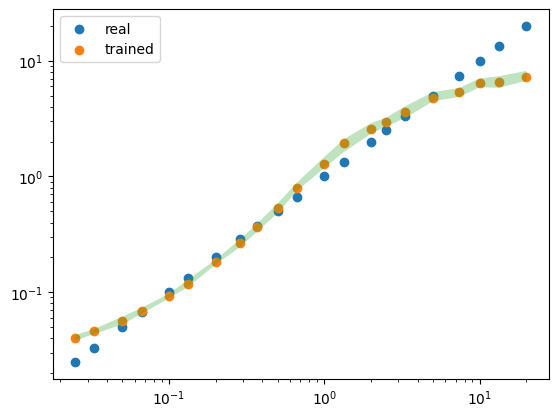

In [220]:
plt.scatter(rs,rs,label='real')
plt.scatter(rs,np.array(Bootstrap_mean),label='trained')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.savefig('regression.png')

In [221]:
def test():
    model.eval()
    predictions = []
    total_loss = 0
    true_values = []
    with torch.no_grad():
        for data in testloader:
            data = data.to(device)
            output = model(data)
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item() * data.num_graphs
            predictions.append(output.cpu())
            true_values.append(data.y.cpu())
    return torch.cat(predictions, dim=0), torch.cat(true_values, dim=0),total_loss / len(testloader.dataset)

In [222]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [223]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 0.2956


In [224]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [131]:
import pickle

# Assuming 'results' is your dictionary
with open('gnn_regression.pkl', 'wb') as file:
    pickle.dump(results, file)

In [231]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

20.0
13.333
10.0
7.4
5.0
3.333
2.5
2.0
1.333
1.0
0.667
0.5
0.37
0.286
0.2
0.133
0.1
0.067
0.05
0.033
0.025


In [232]:
CI = np.array(Bootstrap_ci)

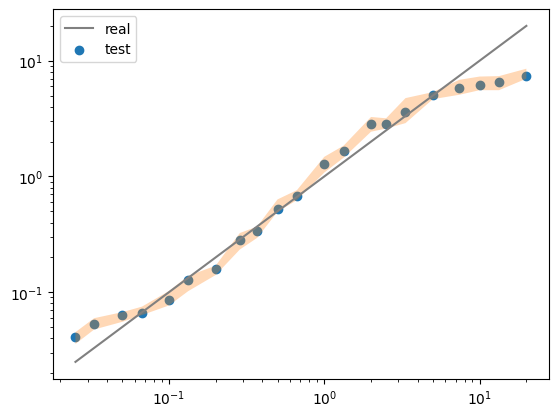

In [227]:
plt.plot(rs,rs,label='real',c='grey')
plt.scatter(rs,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [233]:
rs = rs[::-1]

52
63
60
72
53
53
66
50
58
50
72
60
70
51
57
59
65
67
56
64
62


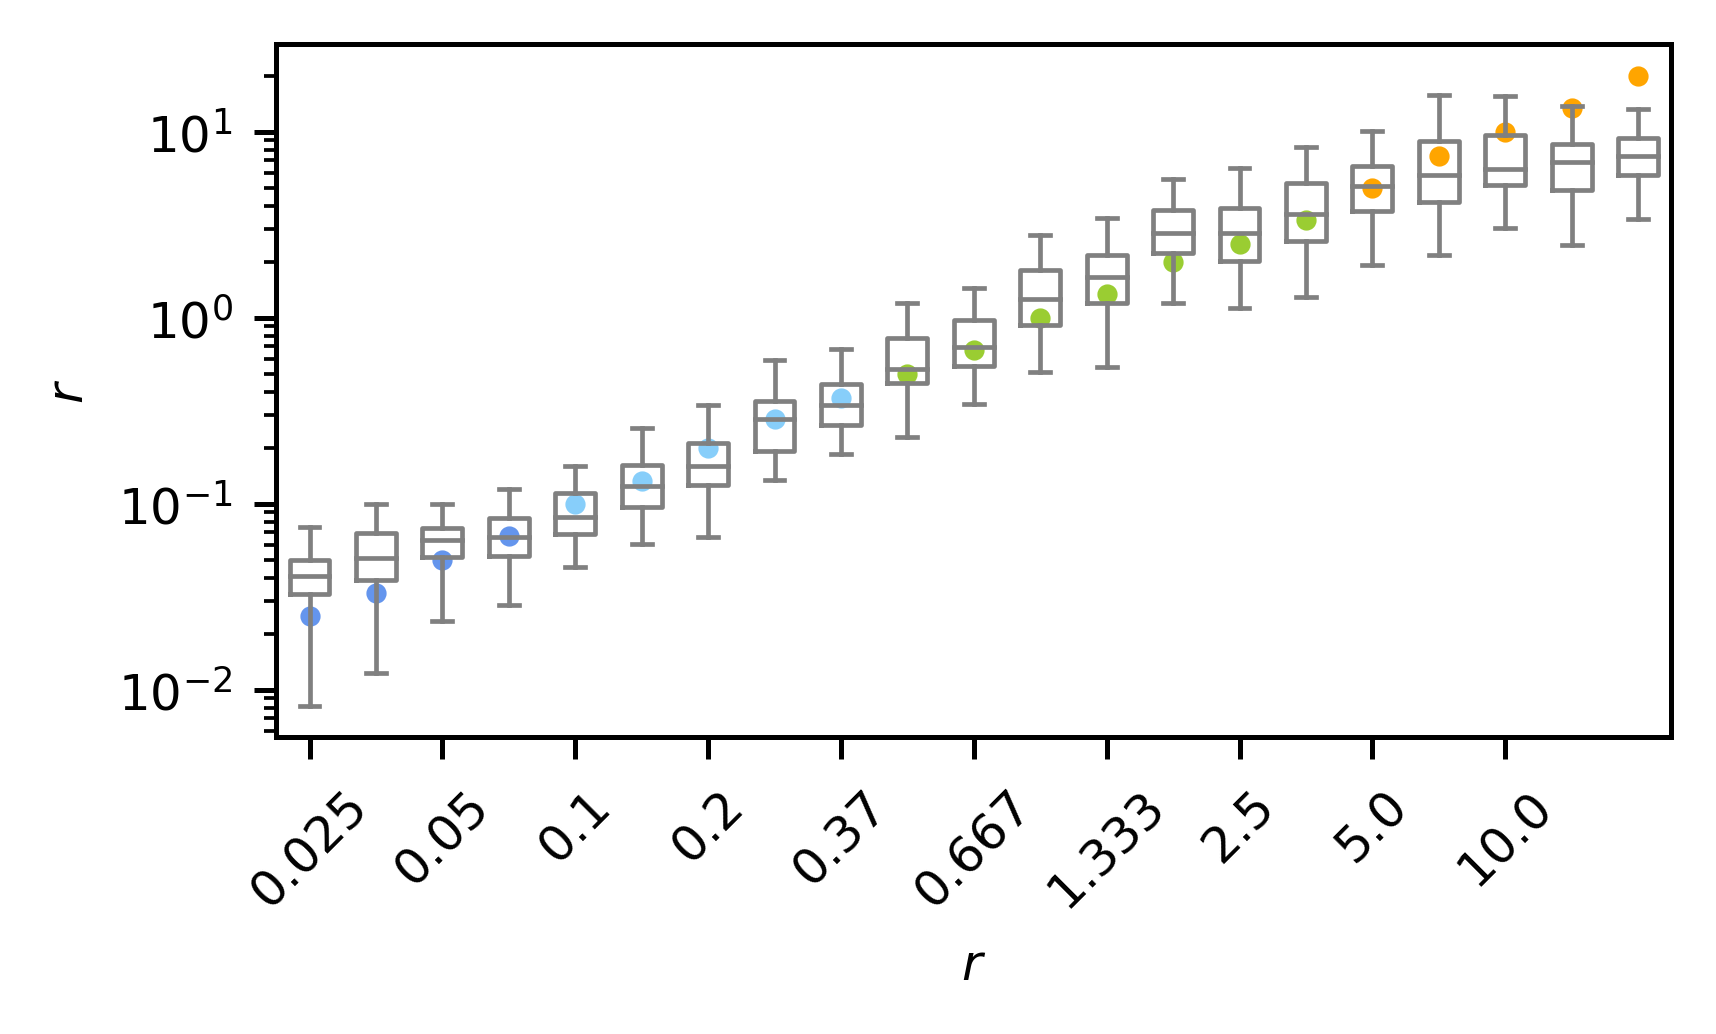

In [234]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
#            5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
#         0.067:3,  0.033:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,2,4,6,8,10,12,14,16,18])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs[[0,2,4,6,8,10,12,14,16,18]])  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

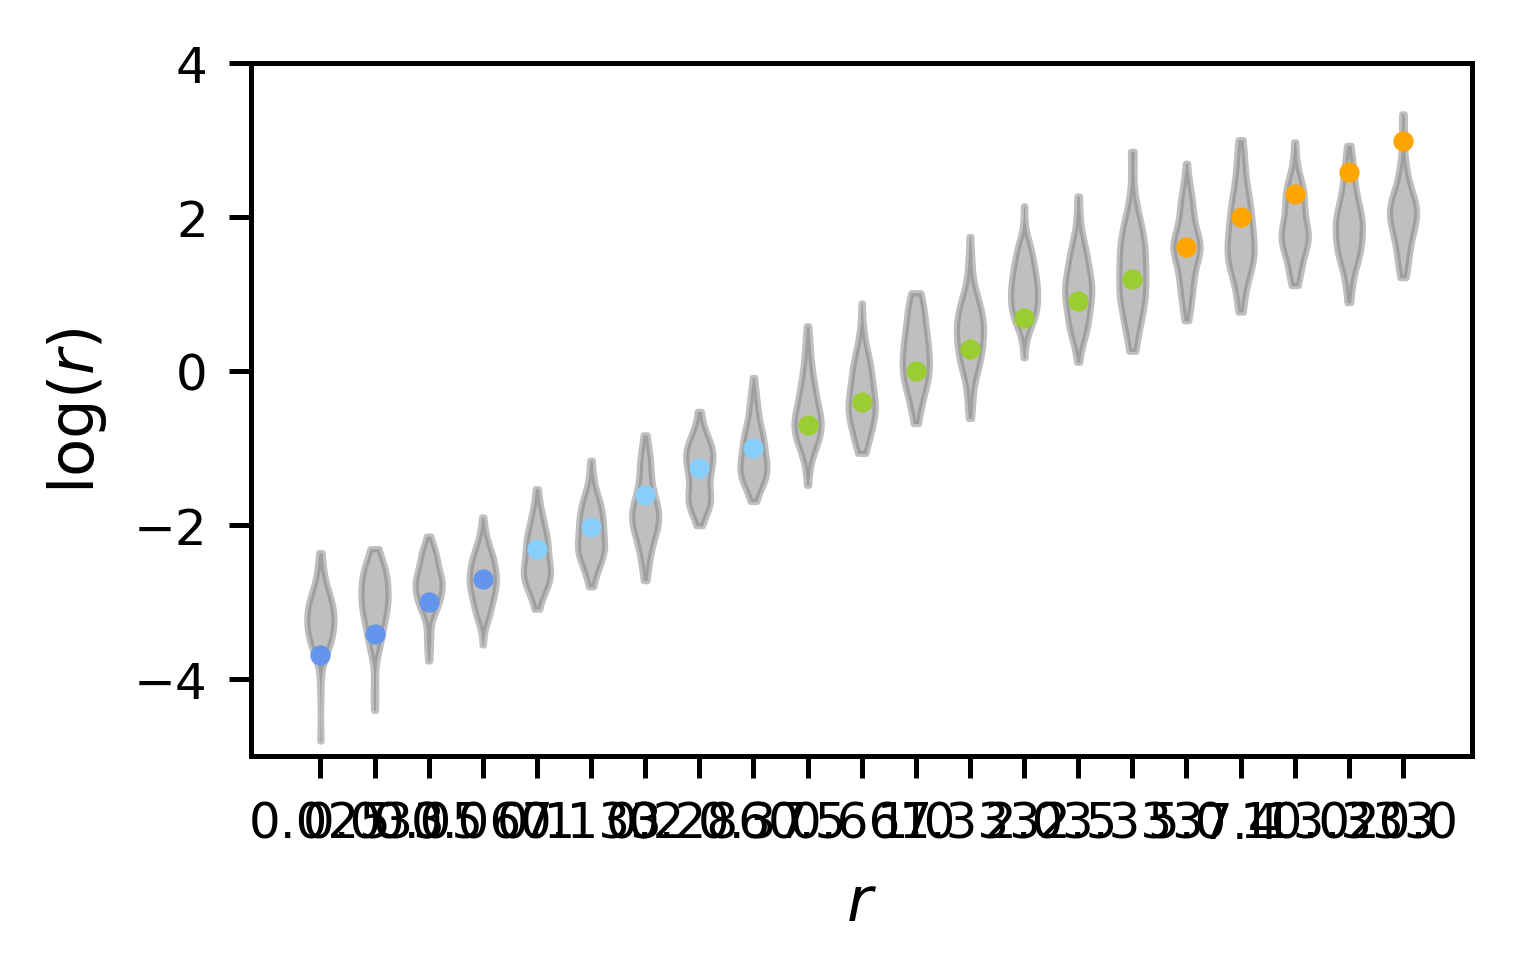

In [235]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' and 'rs' are defined as before

fig, ax = plt.subplots(figsize=(3.5,2), dpi=450)

colors = {0:'orange', 1:'yellowgreen', 2:'lightskyblue', 3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    
    # Creating the violin plot at position r_idx + 1
    vp = ax.violinplot(results[r], positions=[r_idx + 1], showmeans=False, showmedians=False, showextrema=False)
    
    # You can set the color of each part of the violin plot
    for pc in vp['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('grey')
        pc.set_alpha(0.5)

    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, k, color=colors[c], s=5)

# Setting x-ticks positions and labels
ax.set_xticks(range(1, 22))
ax.set_xticklabels(rs)

# Setting the limits for y-axis and font size for ticks
plt.ylim(-5, 4)
plt.xlabel('$r$')
plt.ylabel('$\log(r)$')
ax.tick_params(axis='both', labelsize=8)

plt.show()


In [237]:
rs = rs[::-1]

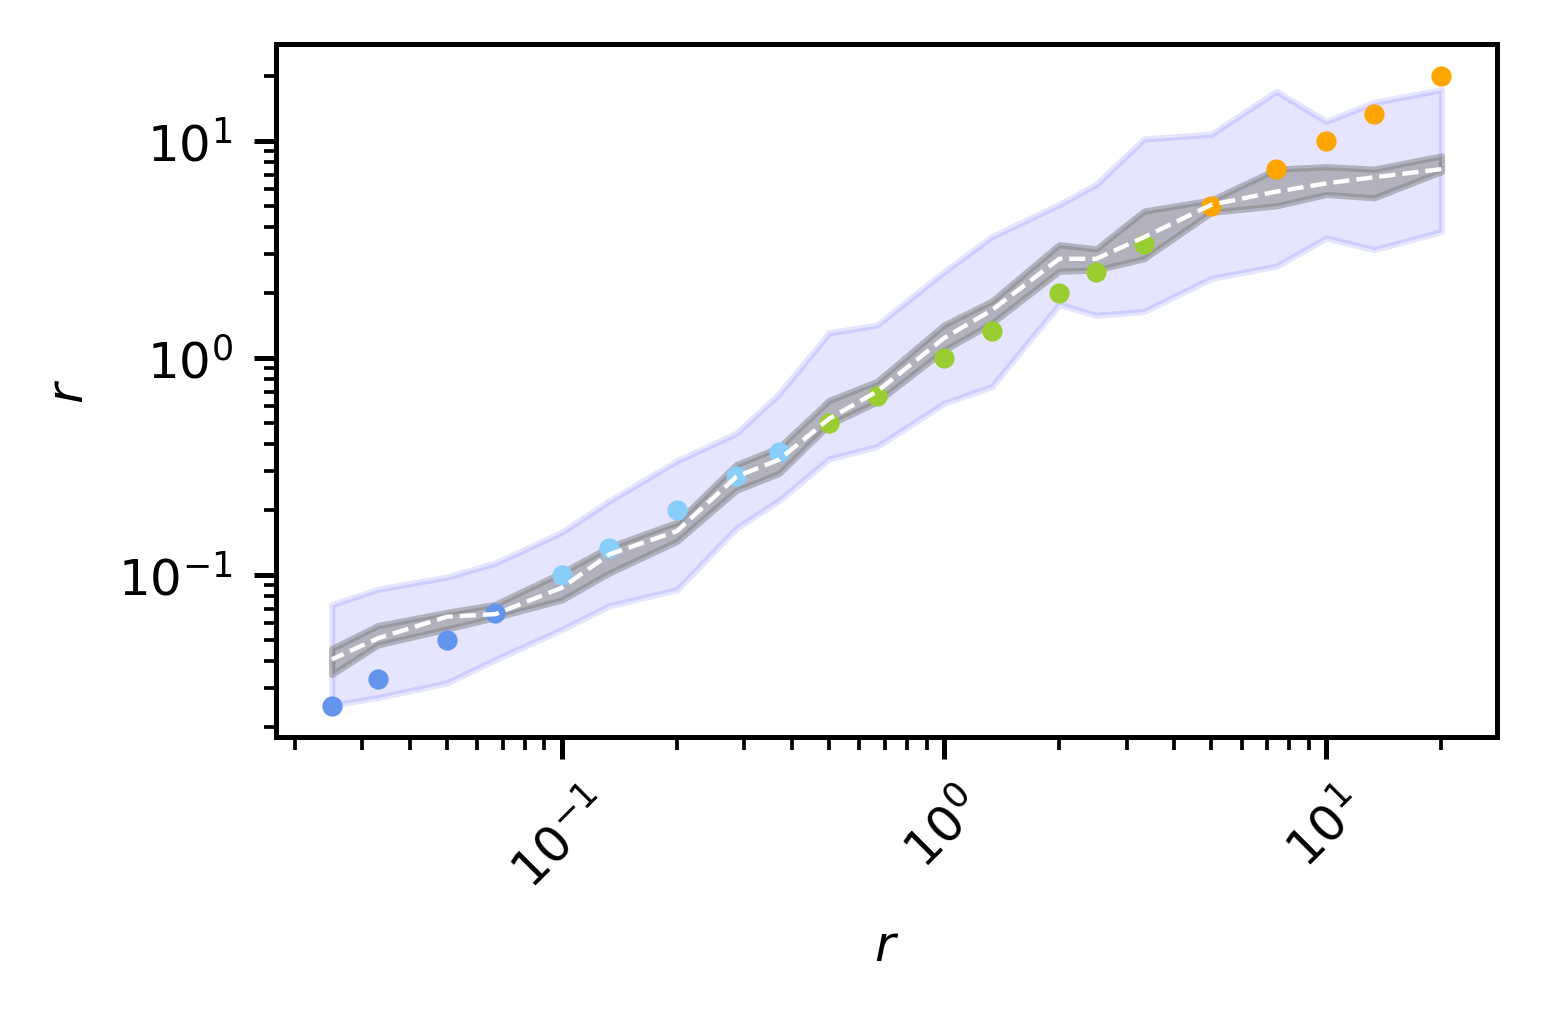

In [238]:
fig, ax = plt.subplots(figsize=(3.5,2),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}

line_properties = dict(linestyle='-', linewidth=0.75, color='gray')

# plt.plot(rs,rs,label='real',c='grey')
plt.plot(rs,np.array(Bootstrap_mean),ls='--',lw=0.7,color='white')

plt.fill_between(rs, np.array(per_5),np.array(per_95),
                 alpha=0.1,color='blue')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.5,color='grey')

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
#     real_pr = np.exp(results[r])
#     std_list.append(np.std(real_pr))
#     median_list.append(np.median(real_pr))

    
#     ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
#                boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
#                whiskerprops=line_properties, widths=0.4,
#            capprops=line_properties,
#               medianprops=dict(linestyle='-', linewidth=1, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r, r, color=myc, s=5)

#     print(len(results[r]))
# plt.plot(rs, median_list,ls='--',lw=0.7)

# Show the plot after adding all boxplots
# label_pos = np.array([0,2,4,6,8,10,12,15,16,18])+1
# ax.set_xticks(label_pos)  # Setting x-ticks positions
# ax.set_xticklabels(rs[[0,2,4,6,8,10,12,15,16,18]])  # Assuming 'rs' is your array of labels
plt.xticks(rotation=45)
plt.yscale('log')
plt.xscale('log')
# plt.ylim(-5,4)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

In [239]:
rs_add = np.array([12.5 ,  4.  ,  0.4 ,  0.08])

In [240]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/unseen/'
#### data preparation
dataset = []
r_class = {12.5:0 ,  4.:1  ,  0.4:2 ,  0.08:3}
for r_idx in range(4):
    r = rs_add[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:]
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

12.5 0
4.0 1
0.4 2
0.08 3


In [241]:
testloader = DataLoader(dataset, batch_size=128, shuffle=True)

/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [208]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")

Test MSE: 0.2969


In [209]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [210]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(4):
    r = rs_add[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

12.5
4.0
0.4
0.08


In [211]:
CI = np.array(Bootstrap_ci)

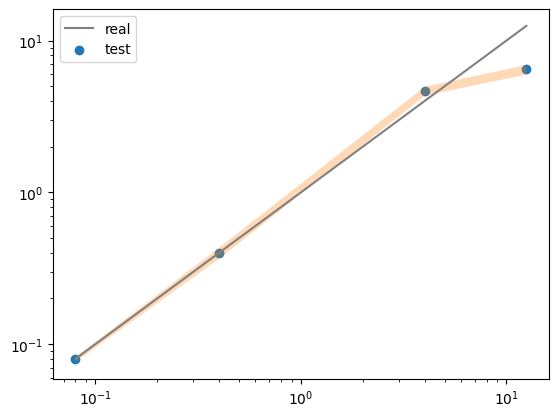

In [212]:
plt.plot(rs_add,rs_add,label='real',c='grey')
plt.scatter(rs_add,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs_add,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

300
300
300
300


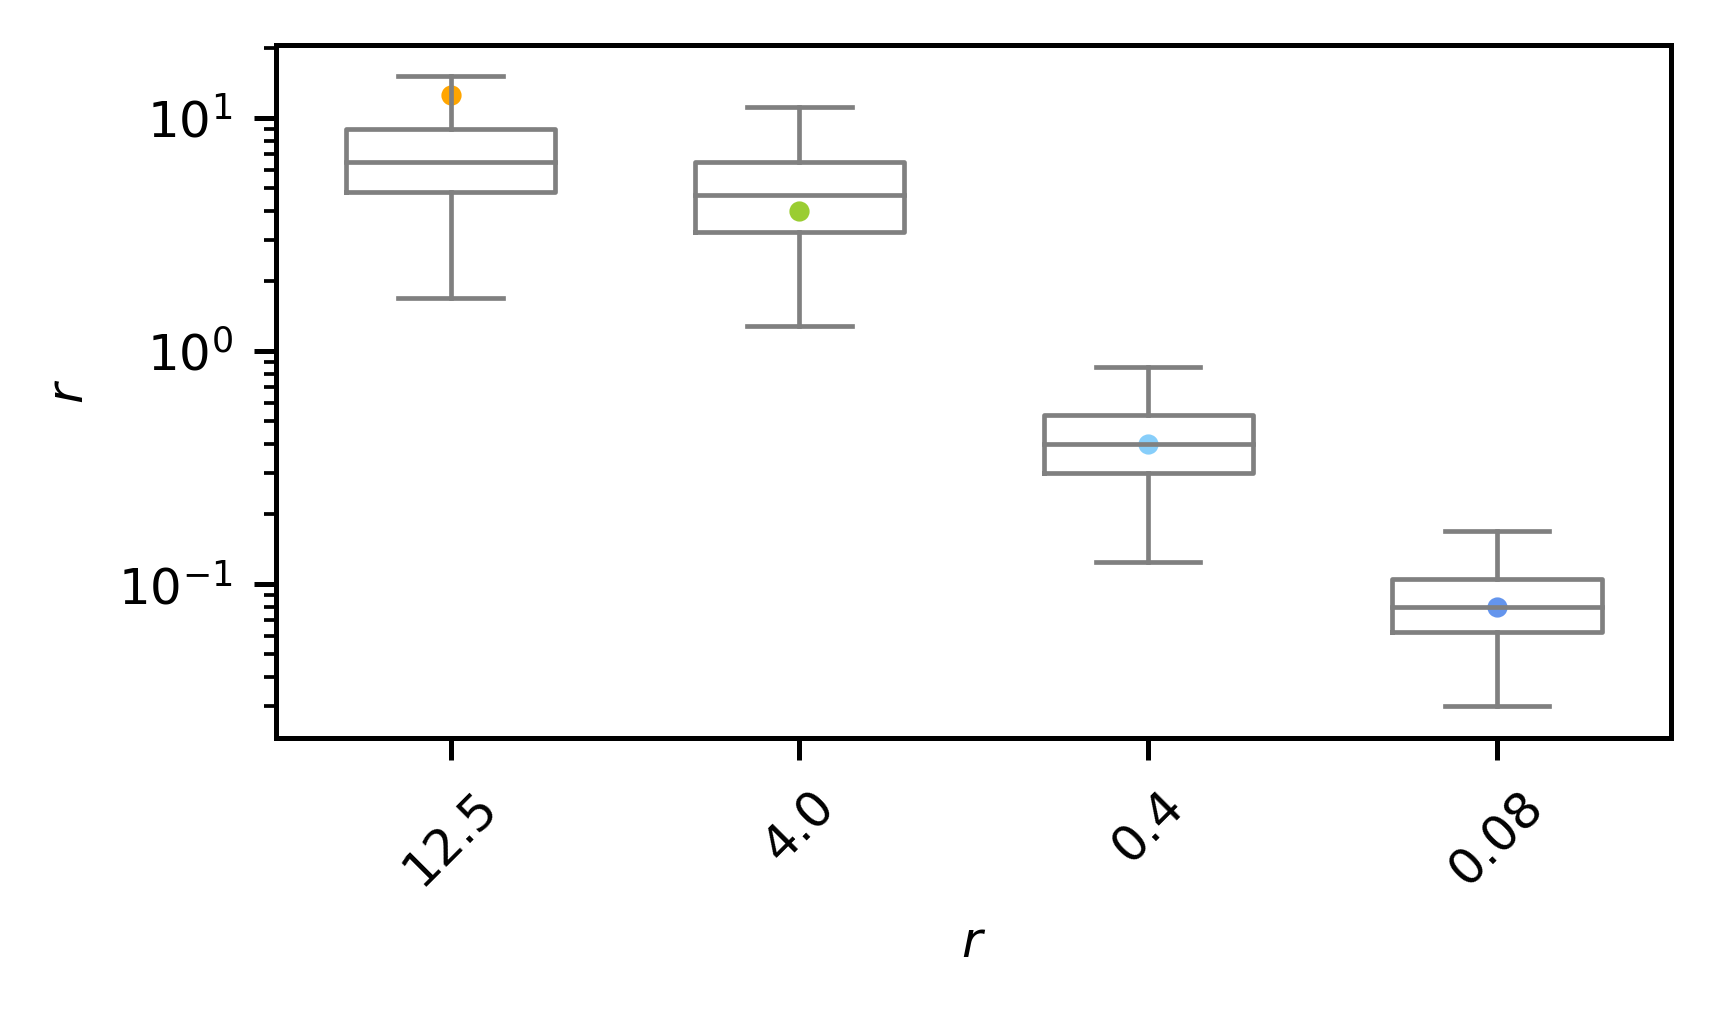

In [213]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
#            5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
#         0.067:3,  0.033:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(4):
    r = rs_add[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,1,2,3])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs_add)  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)